In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgenmulti
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Load the Dataset

In [5]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/'

## scRNA

In [6]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 648 ms, sys: 1.12 s, total: 1.77 s
Wall time: 1.77 s


In [7]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition', 'n_counts'
    var: 'gene_name', 'gene_id', 'exonLength'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

## scATAC

In [8]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')

CPU times: user 1.26 s, sys: 10.8 s, total: 12 s
Wall time: 17.2 s


In [9]:
scatac

AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

# Train the model

In [10]:
network = scgenmulti.VAEArithKeras([scrna.shape[1], scatac.shape[1]],
                                    h_dimension=50, z_dimension=10, other_dimension=50,
                                    learning_rate=0.0002)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 20287)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 20002)        0                                            
__________________________________________________________________________________________________
VAE_0 (Model)                   (None, 20287)        2061707     input_0[0][0]                    
__________________________________________________________________________________________________
VAE_1 (Model)                   (None, 20002)        2032922     input_1[0][0]                    
Total params: 4,087,509
Trainable params: 4,086,609
Non-trainable params: 900
__________________

In [11]:
batch_size = 30000
n_iter = 15
i, j, n = 0, 0, 0
history = []
for n in range(n_iter):
    print('-' * 50)
    print('Iteration: {}'.format(n))
    if i + batch_size < scrna.shape[0]:
        scrna_batch = scrna[i:i+batch_size]
    else:
        select = list(range(i, scrna.shape[0]))
        select += list(range(i + batch_size - scrna.shape[0]))
        scrna_batch = scrna[select]
    if j + batch_size < scatac.shape[0]:
        scatac_batch = scatac[j:j+batch_size]
    else:
        select = list(range(j, scatac.shape[0]))
        select += list(range(j + batch_size - scatac.shape[0]))
        scatac_batch = scatac[select]
        
    i = (i + batch_size) % scrna.shape[0]
    j = (j + batch_size) % scatac.shape[0]
    
    %time history.append(network.train([scrna_batch, scatac_batch], n_epochs=1, batch_size=128, verbose=1))
    
    del scrna_batch
    del scatac_batch
    gc.collect()

--------------------------------------------------
Iteration: 0

Epoch 1/1
30000/30000 [==============================] - 22s 734us/step - loss: 1247.2469 - VAE_0_loss: 486.9824 - VAE_1_loss: 759.9463 - VAE_0_kl_loss: 2.4476 - VAE_0_recon_loss: 487.2508 - VAE_1_kl_loss: 2.4476 - VAE_1_recon_loss: 759.9959
CPU times: user 35.1 s, sys: 13.5 s, total: 48.6 s
Wall time: 41.7 s
--------------------------------------------------
Iteration: 1
Epoch 1/1
30000/30000 [==============================] - 16s 529us/step - loss: 1060.1495 - VAE_0_loss: 391.0640 - VAE_1_loss: 669.0527 - VAE_0_kl_loss: 4.0383 - VAE_0_recon_loss: 391.1322 - VAE_1_kl_loss: 4.0383 - VAE_1_recon_loss: 669.0168
CPU times: user 23 s, sys: 9.8 s, total: 32.8 s
Wall time: 25.2 s
--------------------------------------------------
Iteration: 2
Epoch 1/1
30000/30000 [==============================] - 15s 485us/step - loss: 1073.7551 - VAE_0_loss: 351.7973 - VAE_1_loss: 721.9860 - VAE_0_kl_loss: 7.4302 - VAE_0_recon_loss: 351.8522

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


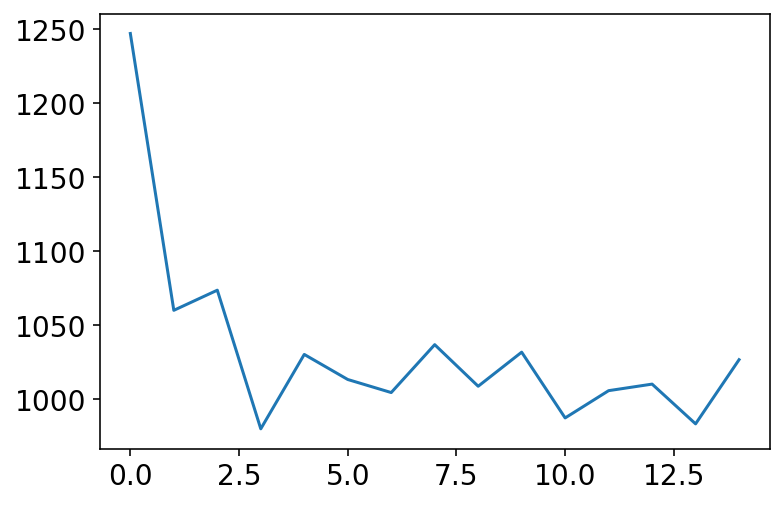

In [12]:
plt.plot([i.history['loss'] for i in history]);

# Visualization

In [13]:
scrna_latent = network.to_latent(scrna.X, 0)[0]
scrna_latent = sc.AnnData(scrna_latent)
scrna_latent.obs = scrna.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

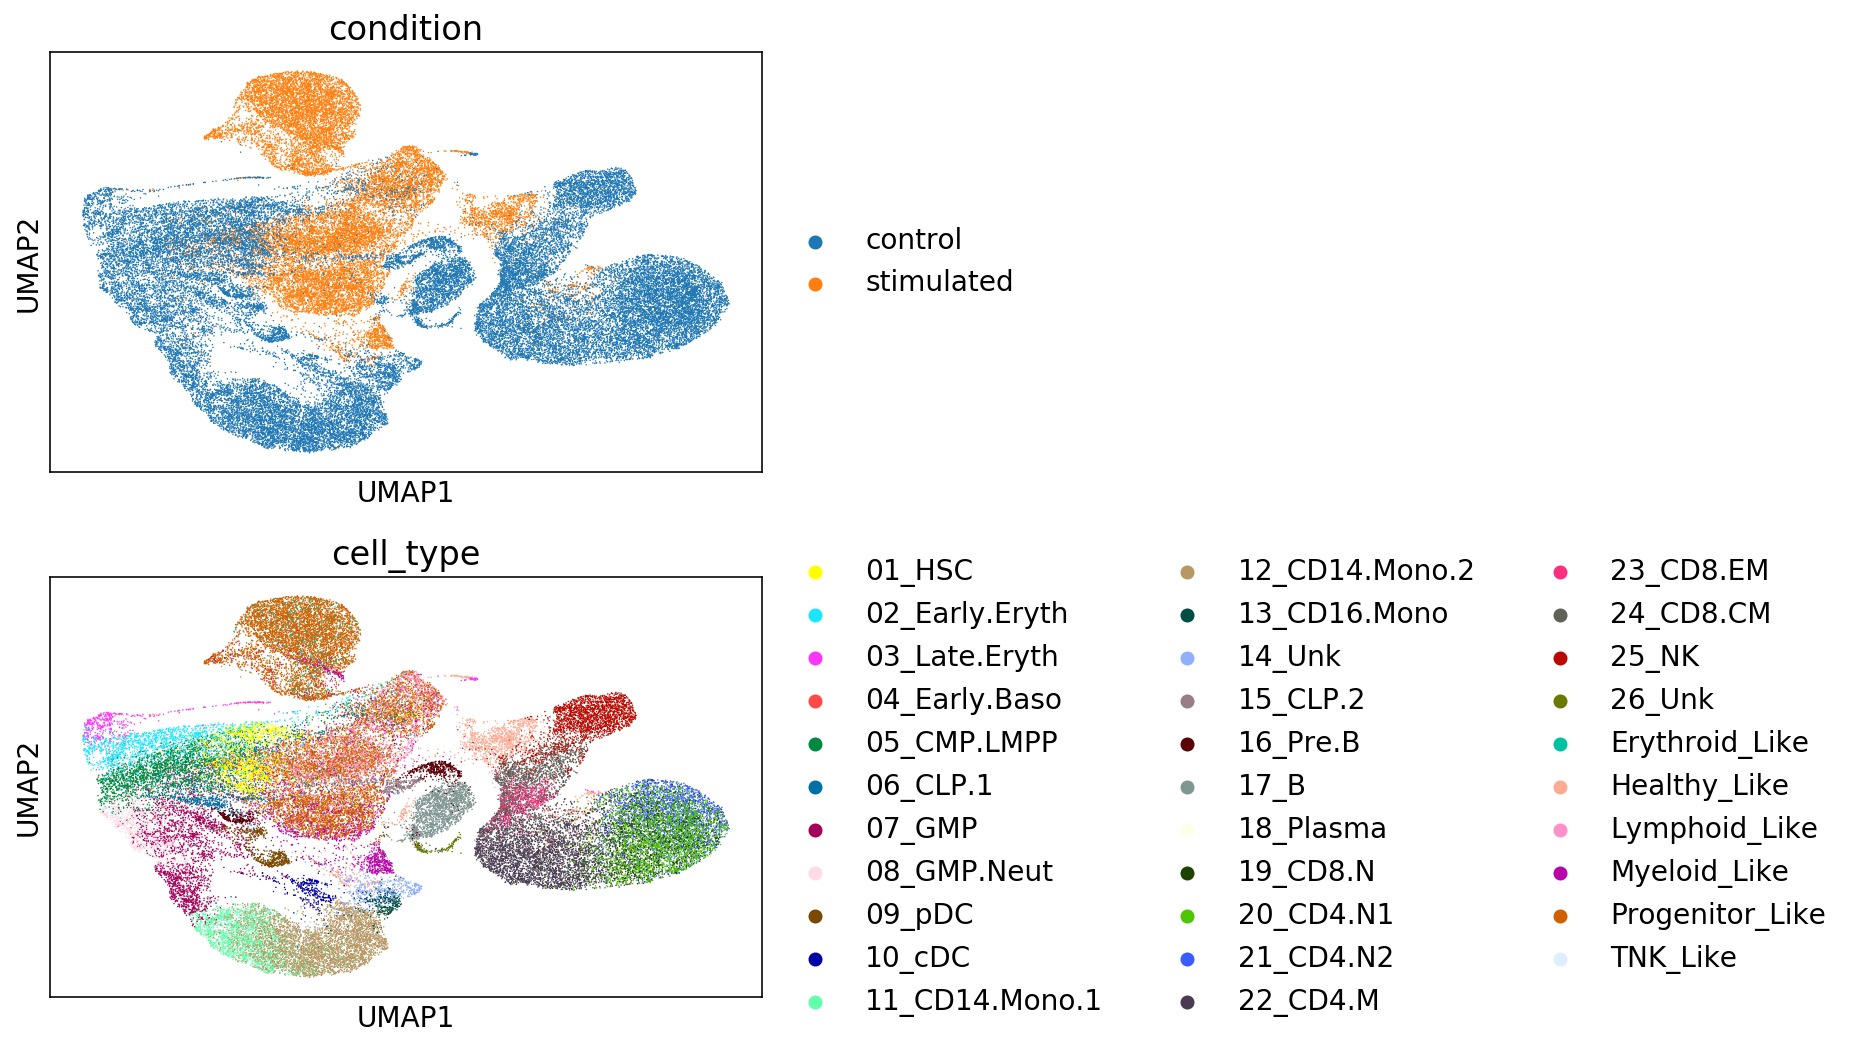

In [14]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

In [15]:
scatac_latent = network.to_latent(scatac.X, 1)[0]
scatac_latent = sc.AnnData(scatac_latent)
scatac_latent.obs = scatac.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


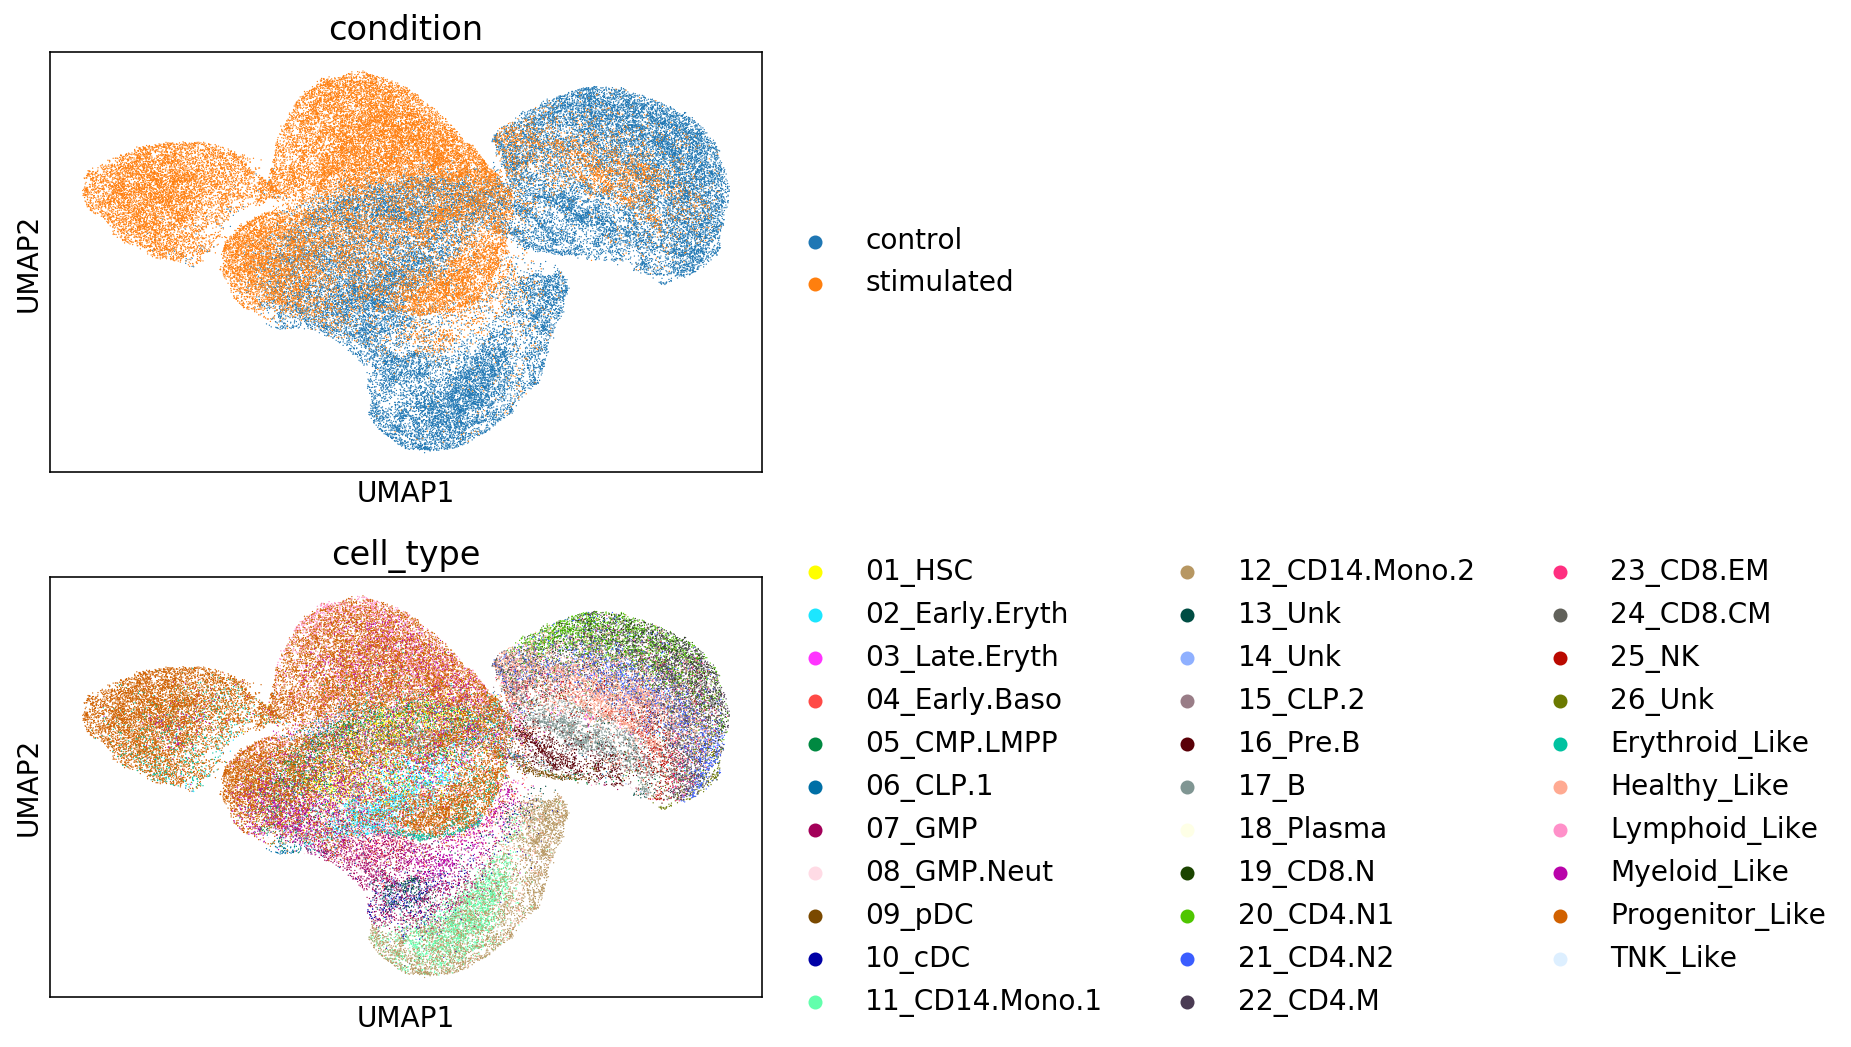

CPU times: user 4min 58s, sys: 5.28 s, total: 5min 4s
Wall time: 1min 38s


In [16]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

In [18]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs
scatacobs = scatac.obs
scrnaobs['modal'] = 'scRNA'
scatacobs['modal'] = 'scATAC'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modal' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


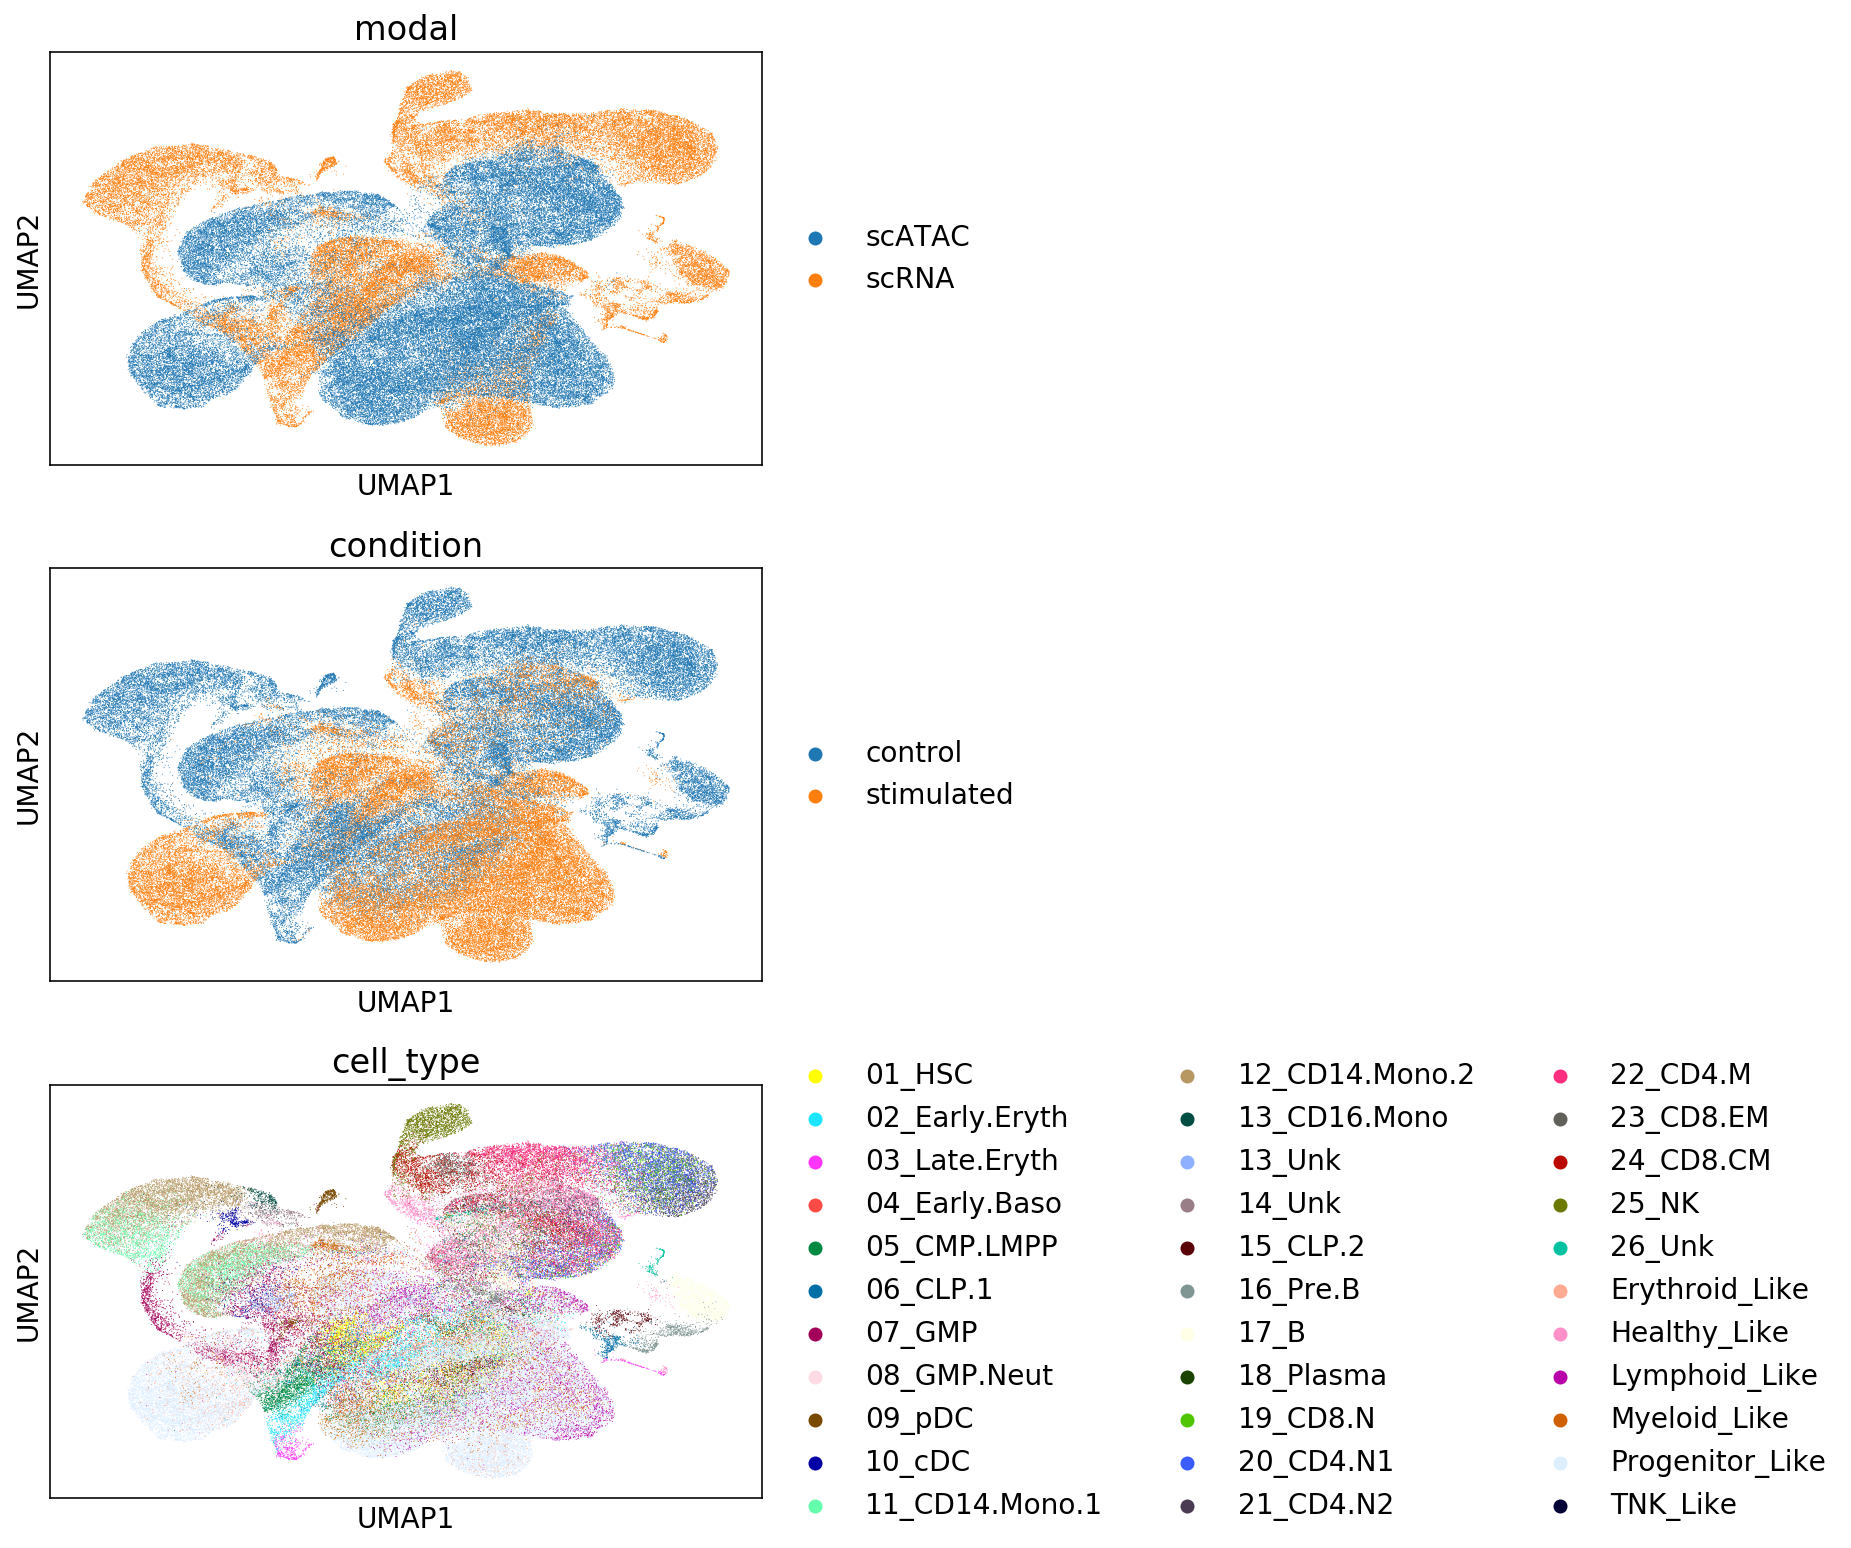

CPU times: user 12min 43s, sys: 14.3 s, total: 12min 58s
Wall time: 3min 7s


In [19]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modal', 'condition', 'cell_type'], ncols=1)

# Integrate

In [20]:
delta = np.mean(scatac_latent.X, axis=0, keepdims=True) - np.mean(scrna_latent.X, axis=0, keepdims=True)
delta

array([[ 1.3152075e+00,  7.0794058e-01, -3.1769276e-05,  8.1596398e-01,
         1.5746909e+00,  1.8206029e+00,  5.1203370e-04,  1.2309530e+00,
         1.5980194e+00,  1.9046102e+00]], dtype=float32)

In [21]:
scall_latent_intg = scall_latent
scall_latent_intg[scall_latent_intg.obs['modal'] == 'scRNA'].X += delta

In [ ]:
%%time
sc.pp.neighbors(scall_latent_intg, random_state=42)
sc.tl.umap(scall_latent_intg, random_state=42)
sc.pl.umap(scall_latent_intg, color=['modal', 'condition', 'cell_type'], ncols=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
